# Quantum Fourier transform and gate-pair tokenization

> A short tutorial showing the compilation of the Quantum Fourier transform (QFT) and extracting tokens via Gate-Pair tokenization (GPE).

In [ ]:
from genQC.imports import *
import genQC.utils.misc_utils as util

from genQC.dataset.config_dataset import ConfigDataset
from genQC.pipeline.multimodal_diffusion_pipeline import MultimodalDiffusionPipeline_ParametrizedCompilation
from genQC.scheduler.scheduler_dpm import DPMScheduler

from genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer
from genQC.platform.simulation import Simulator, CircuitBackendType
from genQC.inference.sampling import decode_tensors_to_backend, generate_compilation_tensors
from genQC.inference.evaluation_helper import get_unitaries
from genQC.inference.eval_metrics import UnitaryInfidelityNorm
from genQC.benchmark.bench_compilation import SpecialUnitaries
import genQC.platform.tokenizer.tensor_tokenizer as gpe

In [ ]:
util.MemoryCleaner.purge_mem()      # clean existing memory alloc
device = util.infer_torch_device()  # use cuda if we can
device

[INFO]: Cuda device has a capability of 8.6 (>= 8), allowing tf32 matmul.


device(type='cuda')

In [ ]:
# We set a seed to pytorch, numpy and python. 
# Note: This will also set deterministic algorithms, possibly at the cost of reduced performance!
util.set_seed(0)

## Load model

Load the pre-trained model directly from [Hugging Face: Floki00/cirdit_multimodal_compile_3to5qubit](https://huggingface.co/Floki00/cirdit_multimodal_compile_3to5qubit).

In [ ]:
pipeline = MultimodalDiffusionPipeline_ParametrizedCompilation.from_pretrained("Floki00/cirdit_multimodal_compile_3to5qubit", device)

The model is trained with the gate set:

In [ ]:
pipeline.gate_pool

['h', 'cx', 'ccx', 'swap', 'rx', 'ry', 'rz', 'cp']

which we need in order to define the `vocabulary`, allowing us to decode tokenized circuits.

In [ ]:
vocabulary = {g:i+1 for i, g in enumerate(pipeline.gate_pool)} 
tokenizer  = CircuitTokenizer(vocabulary)
tokenizer.vocabulary

{'h': 1, 'cx': 2, 'ccx': 3, 'swap': 4, 'rx': 5, 'ry': 6, 'rz': 7, 'cp': 8}

### Set inference parameters

Set diffusion model inference parameters.

In [ ]:
pipeline.scheduler   = DPMScheduler.from_scheduler(pipeline.scheduler)
pipeline.scheduler_w = DPMScheduler.from_scheduler(pipeline.scheduler_w)

timesteps = 40
pipeline.scheduler.set_timesteps(timesteps) 
pipeline.scheduler_w.set_timesteps(timesteps) 

pipeline.lambda_h = 1.5
pipeline.lambda_w = 0.45
pipeline.g_h = 0.4
pipeline.g_w = 0.2

# These parameters are specific to our pre-trained model.
system_size   = 5
max_gates     = 32

For evaluation, we also need a circuit simulator backend.

In [ ]:
simulator = Simulator(CircuitBackendType.QISKIT)

## Compile the QFT unitary

We now compile the 4-qubit QFT.

In [ ]:
samples       = 512
num_of_qubits = 4
prompt        = f"Compile {num_of_qubits} qubits using: ['h', 'cx', 'ccx', 'swap', 'rx', 'ry', 'rz', 'cp']"

U = SpecialUnitaries.QFT(num_of_qubits).to(torch.complex64)

In [ ]:
out_tensor, params = generate_compilation_tensors(pipeline, 
                                      prompt=prompt, 
                                      U=U, 
                                      samples=samples, 
                                      system_size=system_size, 
                                      num_of_qubits=num_of_qubits, 
                                      max_gates=max_gates,
                                      no_bar=False,        # show progress bar
                                      auto_batch_size=256, # limit batch size for less GPU memory usage
                                     )

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[INFO]: (generate_comp_tensors) Generated 512 tensors


For instance, a circuit tensor alongside parameters the model generated looks like this

In [ ]:
print(out_tensor[0])
print(params[0])

tensor([[ 0,  0,  8,  0, -2,  0,  0,  0,  4,  0,  0,  0,  0,  0,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [ 0,  0,  0,  4,  2,  3,  1,  8,  0,  8,  8,  0,  0,  0,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [ 0,  8,  8,  4,  0, -3,  0,  0,  0,  0,  8,  1,  8,  0,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
        [ 1,  8,  0,  0,  0, -3,  0,  8,  4,  8,  0,  0,  8,  1,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9]], device='cuda:0')
tensor([[ 0.0000, -0.7021, -0.9835,  0.0000,  0.0000,  0.0000,  0.0000, -0.9720,  0.0000,  0.6553,  0.2625,  0.0000, -0.7555,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')


### Evaluate and plot circuits

We decode these now to circuits and calculate their unitaries.

In [ ]:
generated_qc_list, _ = decode_tensors_to_backend(simulator, tokenizer, out_tensor, params)
generated_us         = get_unitaries(simulator, generated_qc_list)

We then evaluate the unitary infidelity to our target `U`.

In [ ]:
U_norms = UnitaryInfidelityNorm.distance(
                    approx_U=torch.from_numpy(np.stack(generated_us)).to(torch.complex128), 
                    target_U=U.unsqueeze(0).to(torch.complex128),
                )

We get the following distribution of the infidelities.

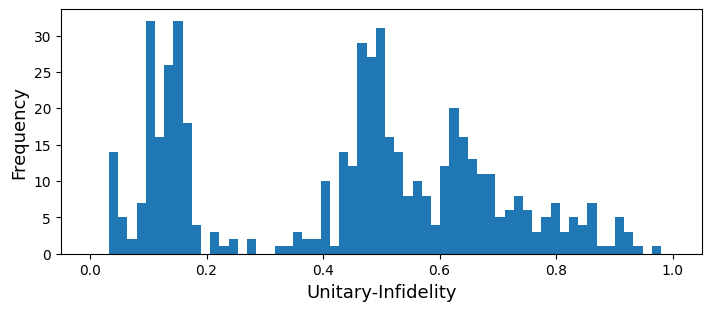

In [ ]:
plt.figure(figsize=(7, 3), constrained_layout=True)
plt.xlabel(UnitaryInfidelityNorm.name(), fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.hist(U_norms, bins=60)
plt.xlim([-0.05, 1.05])
plt.show()

We plot the four best ciruits, w.r.t. the infidelity:

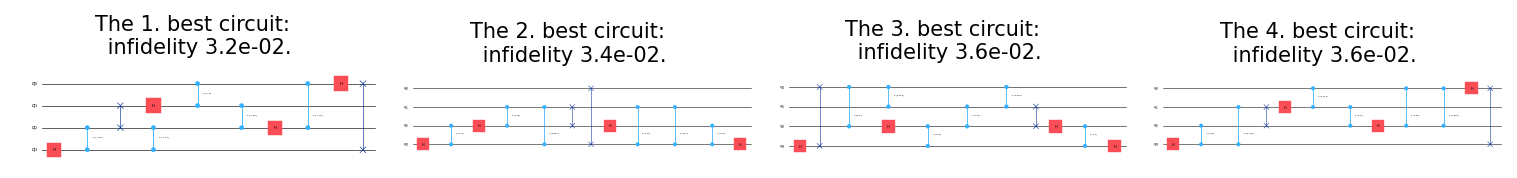

In [ ]:
plot_k_best = 4

idx = np.argsort(U_norms)
fig, axs = plt.subplots(1, plot_k_best, figsize=(10, 2), constrained_layout=True, dpi=150)

for i, (idx_i, ax) in enumerate(zip(idx[:plot_k_best], axs.flatten())): 
    ax.clear()
    generated_qc_list[idx_i].draw("mpl", plot_barriers=False, ax=ax)
    ax.set_title(f"The {i+1}. best circuit: \n infidelity {U_norms[idx_i]:0.1e}.", fontsize=10)

## Gate-Pair tokenization

Now we want to extract reusable substructures (gadgets) from generated circuits. We use all generated tensors in `out_tensor`, regardless if their circuits have good or bad infidelity.

In [ ]:
gate_pair_tokenizer = gpe.GatePairTokenizer(unique_class_values=pipeline.embedder.unique_class_values, 
                                            zero_token=0, 
                                            padding_token=9, 
                                            device="cpu")

Next, we run our proposed Gate-Pair Encoding (GPE) scheme:

In [ ]:
_ = gate_pair_tokenizer.learn(out_tensor.cpu(), max_depth=5, max_iters=100)

  0%|          | 0/100 [00:00<?, ?it/s]

New depth reached 1
New depth reached 2
New depth reached 3
break: max_iters reached


Now we plot the extracted tokens.

In [ ]:
max_depth = 4
topk      = 5

In [ ]:
unpacked_vocab_configs_depths, unpacked_vocab_configs_cnts_depths = \
                    gpe.get_topk_depth_unpacked(gate_pair_tokenizer, num_of_qubits, use_raw=True)

  0%|          | 0/100 [00:00<?, ?it/s]

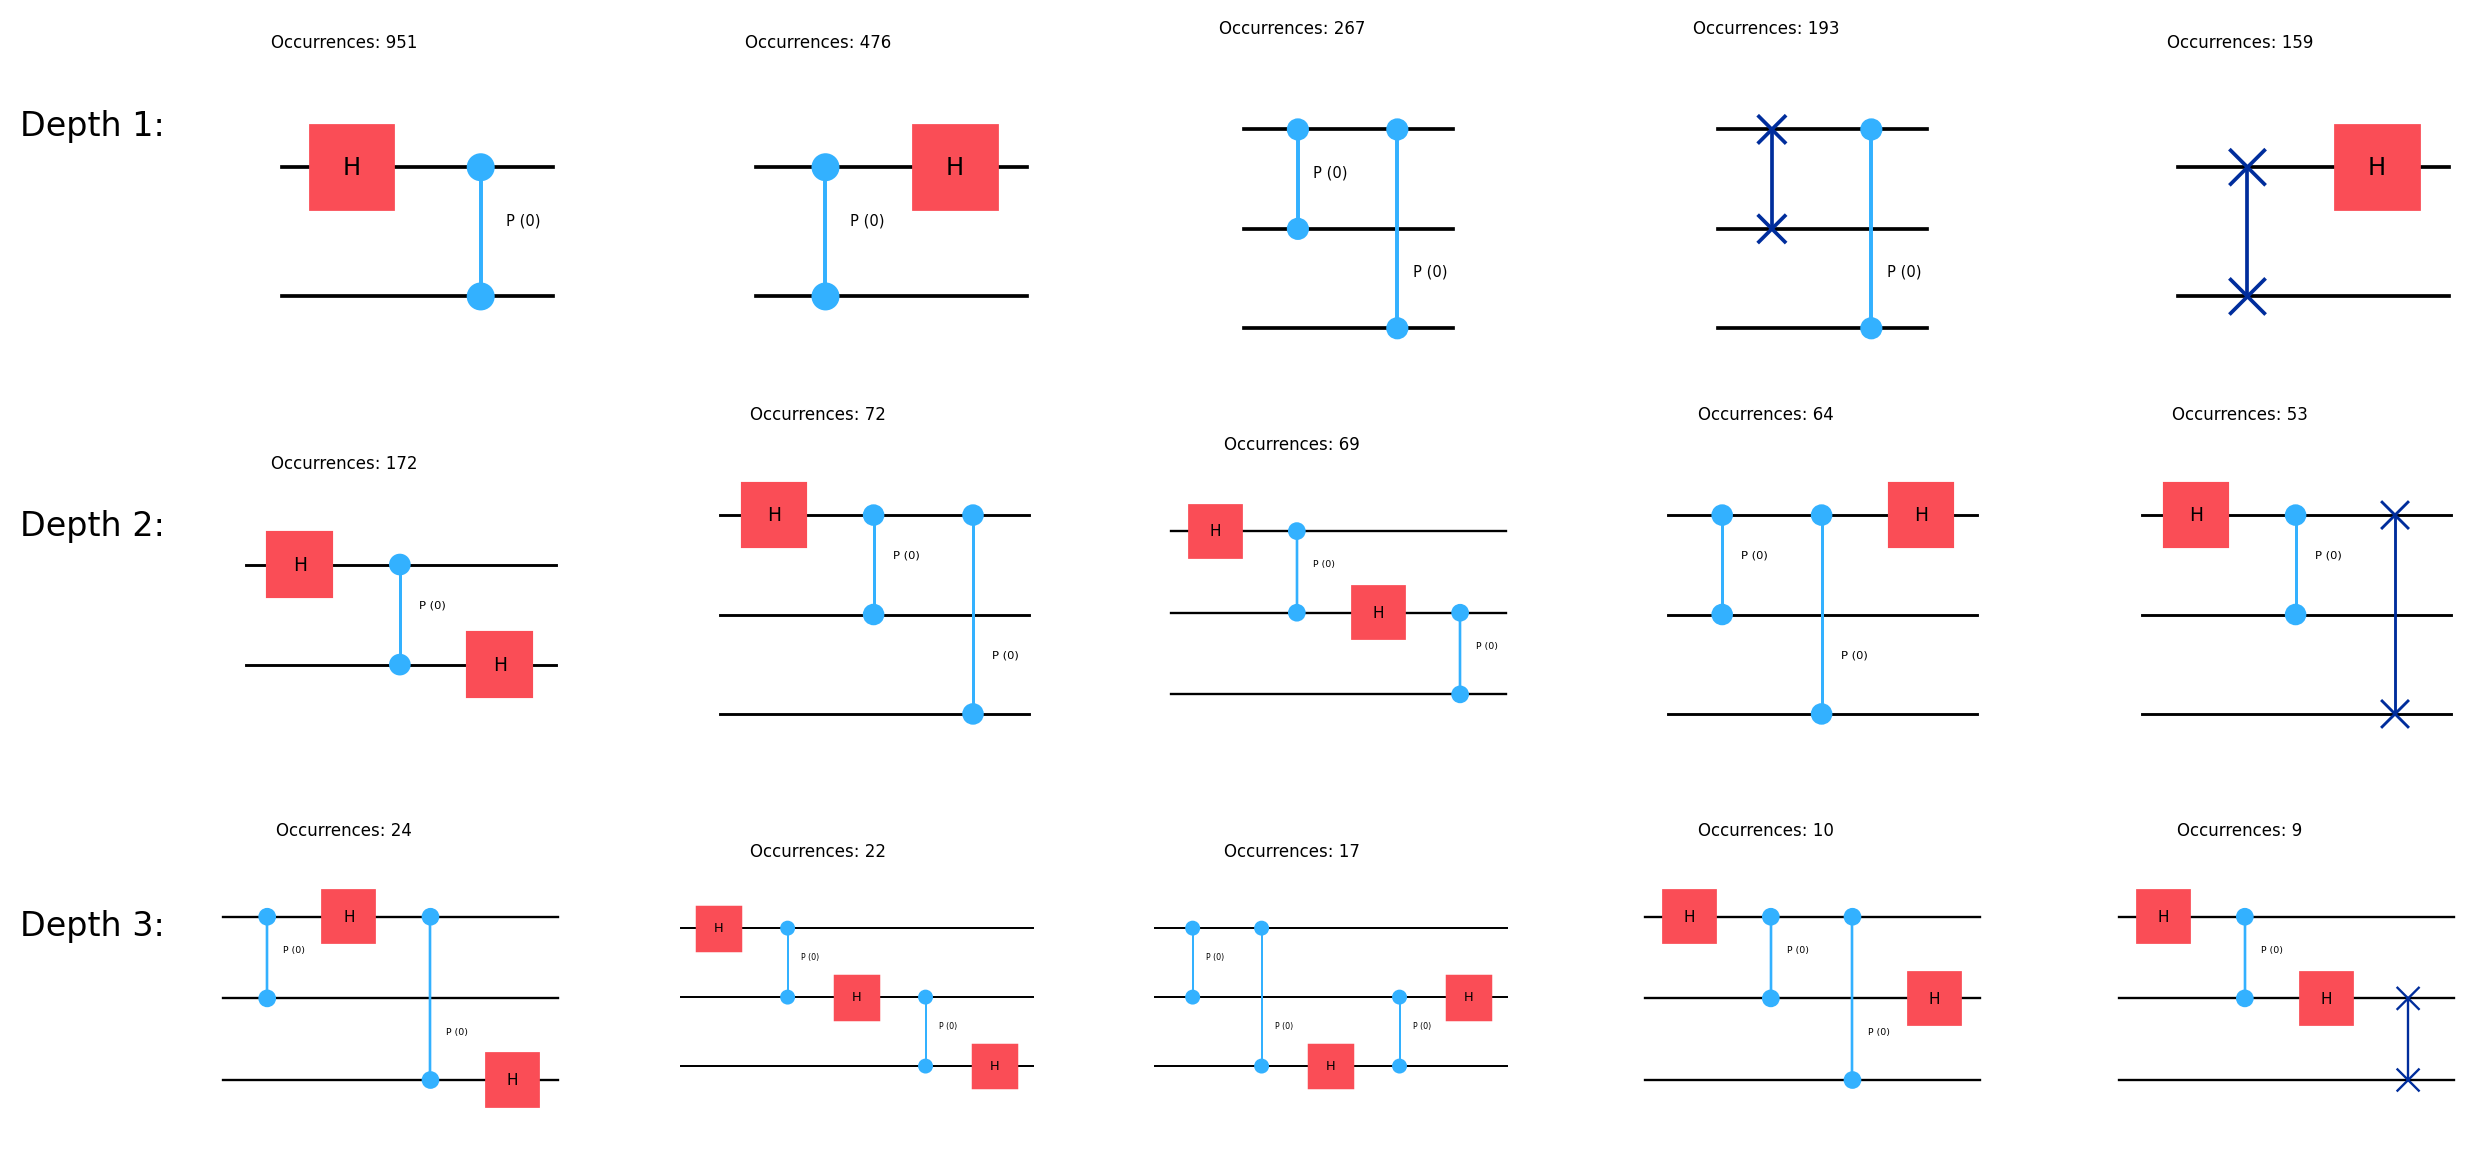

In [ ]:
max_depth = min(max_depth, max(unpacked_vocab_configs_depths.keys()))
fig, axs = plt.subplots(max_depth, topk, figsize=(12, 6), dpi=200)

for ax in axs.flatten():
    ax.clear()   
    ax.set_axis_off()

for (depth, unpacked_vocab_configs), (unpacked_vocab_configs_cnts), axs_sel in \
        zip(unpacked_vocab_configs_depths.items(), unpacked_vocab_configs_cnts_depths.values(), axs):
        
    if depth > max_depth:
        break
   
    for i, (ax, unpacked_vocab_config, unpacked_vocab_config_cnt) in \
            enumerate(zip(axs_sel, unpacked_vocab_configs, unpacked_vocab_configs_cnts)):
        
        zero_ps = torch.zeros((1, unpacked_vocab_config.shape[-1])) - 1
        instr = tokenizer.decode(unpacked_vocab_config, zero_ps)
        qc    = simulator.genqc_to_backend(instr, place_barriers=False)

        #------

        ax.clear() 
        qc.draw("mpl", 
                plot_barriers=False, 
                ax=ax, 
                idle_wires=False)

        for text in ax.texts:
            if 'q' in text.get_text():
                text.set_visible(False)
                text.remove()

        ax.patch.set_facecolor('none')
        ax.patches[0].set_color("none")
                
        ax.set_title(f"Occurrences: {unpacked_vocab_config_cnt.item()}", fontsize=6)
        if i==0:
            plt.figtext(-0.03, 1-(depth-0.7)/max_depth, f"Depth {depth}:", horizontalalignment='left', verticalalignment='top', fontsize=12)

plt.tight_layout()
plt.show()

As we only extract discrete tokens, the parameters of the continuous gates are set to 0 for plotting.

In [ ]:
import genQC
print("genQC Version", genQC.__version__)

genQC Version 0.2.0
